In [8]:
from python_speech_features import mfcc
import matplotlib.pyplot as plt
import numpy as np
import librosa

In [86]:
def plot_fig(audio_path, samples, sample_rate):
    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Raw wave of ' + audio_path)
    ax1.set_xlabel('time (1.0 is {})'.format(sample_rate))
    ax1.set_ylabel('Amplitude')
    for samples_i in samples:
        ax1.plot(np.linspace(0, sample_rate/len(samples_i), sample_rate), samples_i)

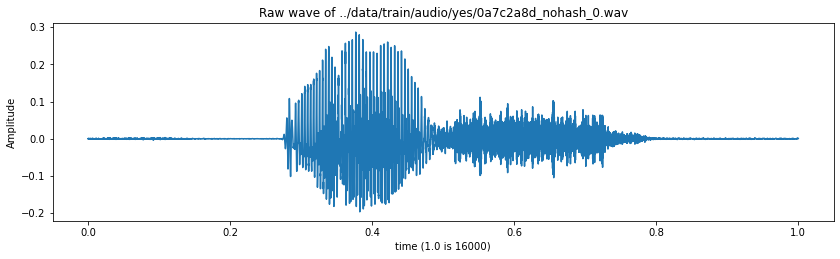

In [74]:
train_audio_path = '../data/train/audio/'
path_to_wav = 'yes/0a7c2a8d_nohash_0.wav'
samples, sample_rate = librosa.load(train_audio_path + path_to_wav, sr = 16000)
plot_fig(train_audio_path + path_to_wav, [samples], sample_rate)

### Pre-emphasis

https://math.stackexchange.com/questions/44216/speech-processing-pre-emphasis-how-does-it-work

$$y[n] = x[n] - α*x[n-1]$$

Signals of low frequency sampled at a highly enough rate, tend to yield adjacent samples of similar numerical value. The reason is that low frequency essentially means slow variation in time and so the numerical values of a low frequency signal tend to change slowly or smoothly from sample to sample. By the subtraction, we remove the part of the samples that did not change in relation to its adjacent samples (what adjacent means is specified by an exponential window parametrized by α) and so what remains is the part of the signal that changes rapidly, i.e. its high-frequency components.

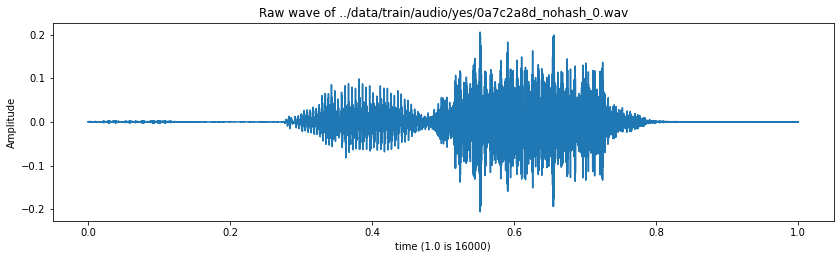

In [75]:
from python_speech_features.sigproc import preemphasis
alpha = 0.97
preemphasised_signal = preemphasis(samples, coeff=alpha)
plot_fig(train_audio_path + path_to_wav, [preemphasised_signal], sample_rate)

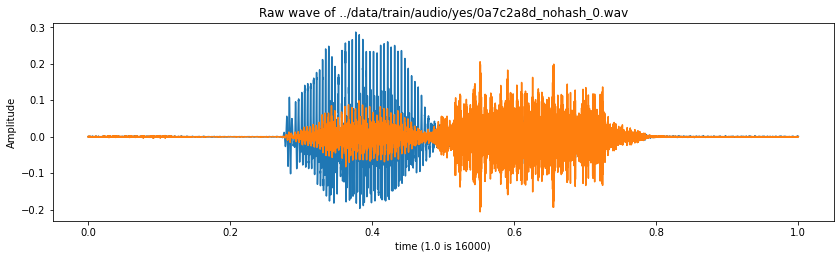

In [76]:
plot_fig(train_audio_path + path_to_wav, [samples, preemphasised_signal], sample_rate)

In [50]:
n_frame = 8000
print("Pre-emphasised signal: {}".format(preemphasised_signal[n_frame-2:n_frame+2]))
print("Signal: {}".format(samples[n_frame-2:n_frame+2]))

Pre-emphasised signal: [-0.02936829  0.05348755 -0.04028259  0.01808411]
Signal: [-0.02575684  0.02850342 -0.01263428  0.00582886]


In [53]:
pr_signal_at_the_moment = round(preemphasised_signal[n_frame], 4)
signal = samples[n_frame] - alpha*samples[n_frame-1]
print("Pre-emphasised signal at the moment: {} \ncomputation: {}".format(pr_signal_at_the_moment, signal))

Pre-emphasised signal at the moment: -0.040300000458955765 
computation: -0.0402825927734375


## Framing

https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

After pre-emphasis, we need to split the signal into short-time frames. The rationale behind this step is that frequencies in a signal change over time, so in most cases it doesn’t make sense to do the Fourier transform across the entire signal in that we would lose the frequency contours of the signal over time. To avoid that, we can safely assume that frequencies in a signal are stationary over a very short period of time. Therefore, by doing a Fourier transform over this short-time frame, we can obtain a good approximation of the frequency contours of the signal by concatenating adjacent frames.

ypical frame sizes in speech processing range from 20 ms to 40 ms with 50% (+/-10%) overlap between consecutive frames. Popular settings are 25 ms for the frame size, frame_size = 0.025 and a 10 ms stride (15 ms overlap), frame_stride = 0.01.

In [111]:
frame_size = 0.025
frame_stride = 0.01
global frame_length
def windowing(frame_size, frame_stride, signal, sample_rate):
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    return frames

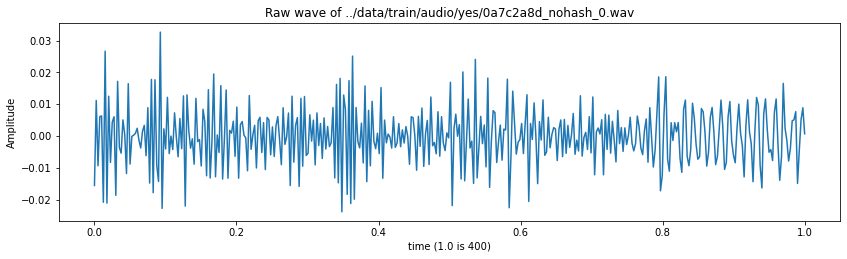

In [118]:
frames = windowing(frame_size, frame_stride, preemphasised_signal, sample_rate)
plot_fig(train_audio_path + path_to_wav, [frames[75]], len(frames[75]))

## WTF???

НА самом деле, сам не до конца понял, что здесь нарисовано, кажется, что все фреймы по отдельности складываются в этот график, но так не должно быть, потому что фреймы вообще не сохраняют общую структуру сигнала по отдельности (достаточно посмотреть на отдельные примеры в коде сверху).

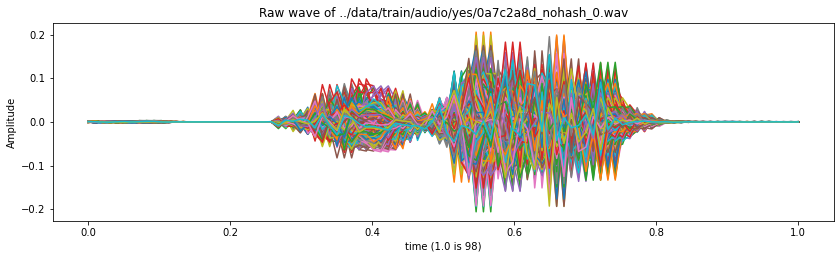

In [90]:
plot_fig(train_audio_path + path_to_wav, [frames], len(frames))

## Window
After slicing the signal into frames, we apply a window function such as the Hamming window to each frame. A Hamming window has the following form:
$$w[n]=0.54−0.46cos(2πnN−1)$$
where, $0≤n≤N−1, N$ is the window length. There are several reasons why we need to apply a window function to the frames, notably to counteract the assumption made by the FFT that the data is infinite and to reduce spectral leakage.

Frame length = 400.0 (set in windowing(...))


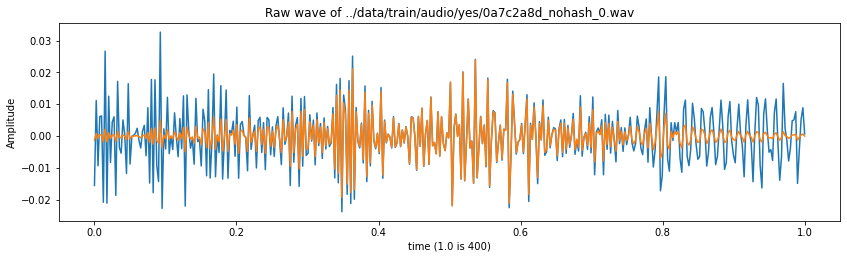

In [125]:
frame_length = frame_size * sample_rate
n_frame = 75
print("Frame length = {} (set in windowing(...))".format(frame_length))
win_frames = frames * np.hamming(frame_length)
plot_fig(train_audio_path + path_to_wav, [frames[n_frame], win_frames[n_frame],], len(frames[n_frame]))